# Multi-spectrum Parallel Fitting with spectral-cube and astropy #

## Authors ##
Eric Koch, Adam Ginsburg, Tom Robitaille

## Learning Goals ##

* Enabling dask for spectral fitting
* Example of fitting in parallel using dask array functions

## Keywords ##

radio astronomy, spectral-line data cubes, spectral fitting, spatial fitting

## Summary ##

This tutorial presents a proof-of-concept demonstration of spectral fitting a whole spectral-line data cube. Using dask, this example splits the cube into subcubes and runs the fitting in parallel on these subcubes. Here, we use [astropy.modeling](https://docs.astropy.org/en/stable/modeling/) to fit a single Gaussian to a small region in M33 mapped in CO(2-1) by the ALMA 7-m (ACA) array (Project ID 2019.1.01182.S).

## Requires ##

```
pip install scipy
pip install astropy
pip install spectral-cube
pip install radio-beam
pip install dask
pip install dask_image
pip install aplpy
```


In [1]:
%matplotlib inline

import warnings
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
import astropy.units as u
from astropy.io import fits
from astropy.modeling import models, fitting
import aplpy

import dask
import dask.array as da
from dask_image import ndmeasure


We will download the $\sim10$ MB data cube available online for this tutorial:

In [2]:
from astropy.utils.data import download_file

datafile = download_file(
    'https://zenodo.org/record/4050489/files/M33_ALMA_ACA_12CO21.cutout.fits',
    cache=True, show_progress=True)

# Note that the datafile will not end in ".fits". Because of that, we need to specify the format
# When the file name end in "fits", `format` will not need to be specified 
cube = SpectralCube.read(datafile, format='fits', use_dask=True)

# Use km/s as the spectral unit
cube = cube.with_spectral_unit(u.km / u.s)

This cube is quite small and can be processed in a single chunk by dask (equivalent to using `use_dask=True`). However, larger cubes will be split into $>1$ chunk.

To demonstrate processing a large cube, we will split the tutorial data cube to have 16 chunks. Because the main goal is to fit the spectra, we will keep a single chunk along the spatial axis (set below using `-1` for the 0th axis).

In [3]:
cube = cube.rechunk(chunks=(-1, 16, 16))

## Identifying spectra to fit ##

Model fitting requires sufficiently bright signal, and we want to begin the fitting with reasonable initial parameters.

We will first identify spectra with high signal-to-noise to fit and create a mask containing the signal.

To create the signal mask, we will use a few steps using mathematical morphology to find coherent regions of signal. Signal masking is covered in more detail in [ADD LINK TO MASKING TUTORIAL]().

The goal of the signal mask is to find the most likely regions with real signal, while still recovering the surrounding faint signal. To identify these regions, we will create an initial "low" and "high" signal-to-noise masks, defined as above the $3\sigma$ and $6\sigma$ levels, where the noise level is estimated as the [median absolute deviation](https://docs.astropy.org/en/stable/api/astropy.stats.mad_std.html) along each spectrum:


In [4]:
# Estimate the noise along each line-of-sight
mad_std_plane = cube.mad_std(axis=0)

# Make a low and high mask
low_snr_mask = cube > 3 * mad_std_plane
high_snr_mask = cube > 6 * mad_std_plane

Next, we will label connected regions in `low_snr_mask` and label them:

In [5]:
# Find connected structures
structure = np.ones((3, 3, 3), dtype=bool)

low_snr_mask_labels, num_labels = ndmeasure.label(low_snr_mask.include(),
                                                  structure=structure)

print(f"Initial number of regions found: {num_labels.compute()}")

Initial number of regions found: 336


Many regions are found. However, we only expect a few real regions of signal based on visual inspection.

Most of the regions are small, spurious regions due to noise. To remove these, we will apply 2 criteria:

1. All regions in `low_snr_mask` must contain $>5$ pixels above $6\sigma$ (the `high_snr_mask`).
2. Regions in `low_snr_mask` must contain $>40$ pixels.

Regions that do not satisfy these criteria are removed from the mask.

The exact number of pixels for each criteria are approximate only and determined by checking different thresholds. A good rule-of-thumb is for regions in `low_snr_mask` to be greater than the number of pixels in the beam. $40$ pixels is approximately the number of pixels within the FWHM of the beam for these data.

In [6]:
num_pixels_in_high_snr_mask = ndmeasure.sum(high_snr_mask.include(),
                                 label_image=low_snr_mask_labels,
                                 index=range(1, num_labels.compute() + 1)).compute()

num_pixels_in_low_snr_mask = ndmeasure.sum(low_snr_mask.include(),
                                           label_image=low_snr_mask_labels,
                                           index=range(1, num_labels.compute() + 1)).compute()

signal_mask = low_snr_mask.include().compute()
low_snr_mask_labels = low_snr_mask_labels.compute()

for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, num_pixels_in_low_snr_mask)):
    if high_pix_num > 5 and low_pix_num > 40:
        continue

    signal_mask[low_snr_mask_labels == num + 1] = False

The remaining number of regions is:

In [7]:
signal_mask_labels, num_labels = ndmeasure.label(signal_mask,
                                                  structure=structure)

print(f"Final number of regions found: {num_labels.compute()}")

Final number of regions found: 3


This is far closer to our expectation based on visual inspection.

We apply a final step to better recover faint emission. Because we cut all signal below $3\sigma$, the low level emission around the remaining regions will not be included. To improve the recovery, we extend the signal mask by 1 spectral channel in each direction:

In [8]:
# Extend the signal mask by 1 spectral channel in each direction for the remaining structures
# This is to include low level emission below the 3 sigma cutoff, but only for the remaining structures
# that are likely to be real.
# The same operation can be achieved by "rolling"

posns = np.where(signal_mask > 0)

signal_mask[posns[0] + 1, posns[1], posns[2]] = True
signal_mask[posns[0] - 1, posns[1], posns[2]] = True

In total, 3 regions satisfy our criteria as "real" emission.

We will mask the cube in two ways for this tutorial:

* `masked_cube` which is masked with `signal_mask` -- We will use this cube to estimate initial parameters by making moment maps.
* `spatmasked_cube` which only masks in the *spatial dimensions* -- We will use this cube for fitting so that the fits use the entire spectrum whereever there is sufficiently bright signal.

In [9]:
masked_cube = cube.with_mask(signal_mask)

spatmasked_cube = cube.with_mask(signal_mask.sum(axis=0) > 0)

To visualize the structures kept in the signal mask, we create a moment 0 (integrated intensity) map:

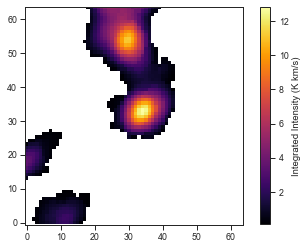

In [10]:
masked_moment0 = masked_cube.moment0()
plt.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar()
cbar.set_label('Integrated Intensity (K km/s)')


The regions kept after masking is what we expect: 2 Giant Molecular Clouds (GMCs) in the field-of-view and two fainter regions that have been cut-off in the tutorial data.

The white regions are where the data has been masked completely (i.e., the whole spectrum is now a `NaN` in the masked cubes).

All of the unmasked spectra will be included in the fitting below.

## Initial guesses ##

We want to make reasonable initial model guesses to assist the fits in converging. For a single Gaussian model, we need to estimate:
1. The peak amplitude
2. The mean velocity (velocity at the peak)
3. The line width (standard deviation of the Gaussian)

These 3 quantities can be estimated by (1) the peak of each spectra; (2) the moment 1 (centroid); and (3) the line width from the second moment or an equivalent estimator.

To make these maps, we will use `masked_cube`, the full signal mask including along the spectral dimension.

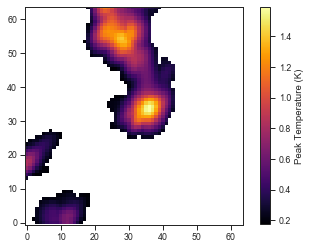

In [11]:
# 1. peak of each spectra
masked_peaktemp = masked_cube.max(axis=0)
plt.imshow(masked_peaktemp.value, origin='lower', cmap='inferno')
cbar = plt.colorbar()
cbar.set_label('Peak Temperature (K)')


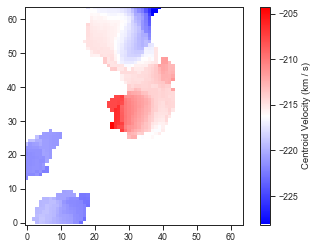

In [12]:
# 2. Moment 1 (centroid velocity)
masked_moment1 = masked_cube.moment1()
plt.imshow(masked_moment1.value, origin='lower', cmap='bwr')
cbar = plt.colorbar()
cbar.set_label('Centroid Velocity (km / s)')


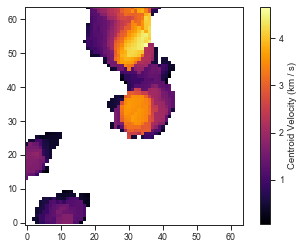

In [13]:
# 3. Second moment line width
masked_lwidth = masked_cube.linewidth_sigma()
plt.imshow(masked_lwidth.value, origin='lower', cmap='inferno')
cbar = plt.colorbar()
cbar.set_label('Centroid Velocity (km / s)')


An alternate "effective" line width can be made by assuming that the spectra are a single Gaussian. For the tutorial data cube, this a reasonable assumption.

The "effective" line width uses the relation between peak intensity, line width, and integrated intensity for a Gaussian:
$$ I = \sqrt{2\pi} T_{\rm peak} \sigma. $$

Solving for the "effective" line width gives:
$$ \sigma = \frac{I}{\sqrt{2\pi} T_{\rm peak}}. $$

* [ ] TODO: add cites


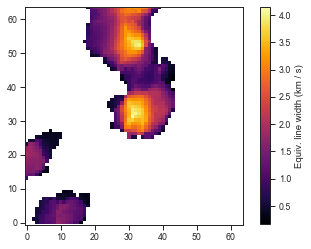

In [14]:
# 3b. "equivalent" line width
masked_equivwidth = masked_moment0 / (np.sqrt(2 * np.pi) * masked_peaktemp)
plt.imshow(masked_equivwidth.value, origin='lower', cmap='inferno')
cbar = plt.colorbar()
cbar.set_label('Equiv. line width (km / s)')


The line widths estimated from the second moment and "effective" methods are similar for the tutorial data. We will use the effective line width as the initial line width guesses for the fitting, but the line width from the second moment works similarly well.

These three maps will be fed in as "guesses" for fitting.

## Chunk fitting ##

Above, we specifically set `cube` to have 16 chunks, each with a shape of $(300, 16, 16)$. *Note that each chunk spans the entire spectral dimension. This is critical for spectral fitting. To enforce this generally for large cubes, use `cube.rechunk(chunk=(-1, 'auto', 'auto'))`*.

To fit the entire cube in parallel, we start with a function for fitting the spectra in each chunk. This will be a bit more complex compared with the single spectrum fitting in the ADD LINK HERE [spectral-cube and astropy fitting tutorial]() with the main difference being a loop over all spectra in the chunk (so in this case $16^2=256$ spectra).

`spectrum_fit_gaussian` below takes each chunk for fitting, along with specifying the `spectrum_axis` and `guesses` arrays. The additional keyword arguments enable additional printing to the terminal (`debug=True`) and information about the location of each chunk in the whole cube (`block_info`; see below and the [dask documentation](https://docs.dask.org/en/latest/array-api.html#dask.array.map_blocks)).

In [15]:
def spectrum_fit_gaussian(subcube, spectrum_axis=None, guesses=None, block_info=None, debug=False):
    '''
    Fit a single Gaussian model to all spectra in the given subcube.

    Masked spectra (i.e., all NaNs) are skipped when fitting.

    Parameters
    ----------
    subcube : `~dask.array.Array`
        The dask array chunk to be fit.
    spectrum_axis : numpy.ndarray
        The spectral axis values. This can *NOT* be an `astropy.quantity` with units.
    guesses : list of numpy.ndarray
        3-element list containing the (1) peak amplitude, (2) mean velocity, and
        (3) line width initial guesses.
    block_info : None, dict
        Information about the `subcube` block. Used by `~dask.array.map_blocks`.
    debug : bool, optional
        Enable to print basic information to the terminal.

    Returns
    -------
    results : numpy.ndarray
        The fit results for the Gaussian fits. The array will have the shape:
        (3, spatial dimension 1, spatial dimension 2).

    '''

    # We expect a 3D shape in all cases.
    subcube_3D = da.atleast_3d(subcube)

    # But if the initial number ofdimensions is 1 (so a single spectrum), we
    # want the 0th axis to always be the spectral axis.
    if subcube.ndim == 1:
        subcube_3D = subcube_3D.swapaxes(0, 1)

    # Initialize an all NaN results array
    results = np.zeros((3, ) + subcube_3D.shape[1:], dtype=float) * np.NaN

    inds = np.indices(subcube_3D.shape[1:])
    y_inds, x_inds = inds

    # When no block_info is given, or dask uses a string "placeholder",
    # assume there is only one block
    if block_info is None or isinstance(block_info, str):
        loc = [0, 0, 0]        
    else:
        # Otherwise, we need information the lower corner of `subcube` to
        # use the correct guesses.
        if debug:
            print(f"array-location {loc}")
            
        loc = [block_range[0] for block_range in block_info[0]['array-location']]


    for y, x in zip(y_inds.ravel(), x_inds.ravel()):

        # Use the block offset to correctly slice the guess arrays
        y_full, x_full = y + loc[1], x + loc[2]

        spec = subcube_3D[:, y, x].compute()

        # Skip all masked data
        if not np.any(spec):
            continue

        # You may need a second check here to enforce enough finite points
        # to fit to (so >number of parameters in the model for unregularized fits)

        # The 1D Gaussian model with initial guesses for parameters
        g_init = models.Gaussian1D(amplitude=guesses[0][y_full, x_full],
                                   mean=guesses[1][y_full, x_full],
                                   stddev=guesses[2][y_full, x_full])

        # If the initial guesses have any NaNs, also skip the fitting.
        if np.isnan(g_init.parameters).any():
            continue

        # And fit with the Levenberg-Marquardt algorithm and least squares statistic.
        fit_g = fitting.LevMarLSQFitter()

        # The initial model, spectral axis (in km/s) and spectrum are passed for the fit
        g_fit = fit_g(g_init, spectrum_axis, spec)

        results[:, y, x] = g_fit.parameters

    return results


Before fitting the whole cube, we will test this function on a single spectrum. The center pixel has a strong CO(2-1) detection, so we will use it for testing.

Both here and for fitting the whole cube, we will use `spatmasked_cube`, where only the spatial extent of the signal mask is used. This allows the full spectrum to be included in the fit where we expect there to be bright emission.

Model: Gaussian1D
Inputs: (&#39;x&#39;,)
Outputs: (&#39;y&#39;,)
Model set size: 1
Parameters:
        amplitude              mean              stddev     
    ------------------ ------------------- -----------------
    1.0974557824901818 -211.55636300015527 4.187837281376681


Text(0.5, 0, &#39;Radio Velocity (km /s)&#39;)

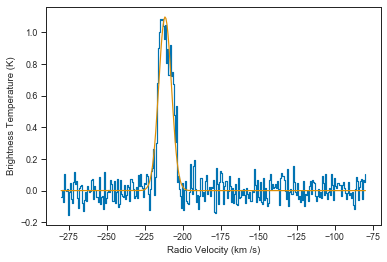

In [16]:
# Pixel location
y, x = 32, 32

spec = spatmasked_cube[:, y, x]

# Slice out the guesses at this location
guesses = [masked_peaktemp[y:y+1, x:x+1].value, masked_moment1[y:y+1, x:x+1].value,
           masked_equivwidth[y:y+1, x:x+1].value]

# Feed in the data. Our "subcube" or chunk is a single spectrum in this case
fit_params = spectrum_fit_gaussian(spatmasked_cube._get_filled_data(fill=np.NaN)[:, y, x], cube.spectral_axis, guesses)

# subcube will be 3D when fitting the full cube
fit_params = fit_params.squeeze()

# Convert the output results to an astropy.model
g_fit_spec = models.Gaussian1D(amplitude=fit_params[0].squeeze(),
                               mean=fit_params[1].squeeze(),
                               stddev=fit_params[2].squeeze())

print(g_fit_spec)

spec.quicklook()
plt.plot(spec.spectral_axis, g_fit_spec(spec.spectral_axis.value))
plt.ylabel("Brightness Temperature (K)")
plt.xlabel("Radio Velocity (km /s)")


The resulting fit is reasonable. There may be additional line structure that requires a more complex model, but that is beyond the scope of this example.

## Fitting the whole cube ##

At this stage, most of the hard work is already done! To expand from fitting a chunk above to the whole cube, we can use dask to handle both loading the data and parallelizing the process.

The magic of dask is using the [dask.array.map_blocks](https://docs.dask.org/en/latest/array-api.html#dask.array.map_blocks) function. We will write an additional function to handle the input and output to complete the fitting with the `map_blocks` function.

In [17]:
def dask_parallel_spectrum_fitter(cube, guesses=None, compute=False):
    """
    Fit all unmasked spectra in a cube.

    Parameters
    ----------
    cube : `~spectral_cube.DaskSpectralCube`
        The spectral cube to fit.
    guesses : list of numpy.ndarray
        3-element list containing the (1) peak amplitude, (2) mean velocity, and
        (3) line width initial guesses.
    compute : bool, optional
        Compute the `map_blocks` computation for fitting. Otherwise, returns the
        uncomputed dask array.
    """

    # Extract the underylying dask array in the cube
    data = cube._get_filled_data(fill=np.nan)

    # Since we are manipulating only the dask array, we need to give the spectrum axis
    # separately
    spectrum_axis = cube.spectral_axis.value

    # If no guesses are given, compute the simplest guesses to use
    if guesses is None:
        guesses = [cube.max(axis=0).value,
                   cube.moment1().value,
                   cube.linewidth_sigma().value]

    # Set output chunk sizes.
    spat_chunks = tuple([chunk[0] for chunk in data.chunks[1:]])

    # Use the dask schedular settings set for `cube`
    with dask.config.set(**cube._scheduler_kwargs):
        # map_blocks applies the fitting function to all chunks
        out = da.map_blocks(spectrum_fit_gaussian,
                            data,
                            spectrum_axis=spectrum_axis,
                            debug=False,
                            drop_axis=[0],  # Tell dask we're not returning the spectral axis
                            chunks=(3,) + spat_chunks, # Instead, the 0th axis will have the 3 fit parameters
                            guesses=guesses)

        # Compute right away if requested
        if compute:
            out = out.compute()

    return out


We will run the fitting on 4 threads (i.e., 4 subcubes will be fit in parallel). This is set in `spatmasked_cube.use_dask_scheduler`. We will also specify the guess arrays, using the equivalent width for the line width guesses.

In [18]:

spatmasked_cube.use_dask_scheduler('threads', num_workers=4)


test = dask_parallel_spectrum_fitter(spatmasked_cube,
                                     guesses=[masked_peaktemp.value, masked_moment1.value, masked_equivwidth.value])


By default, `compute=False` so the above does not actually compute the fitting. However, it constructs the computing graph dask will use for the fitting. Because of that, we can first check if the output array in `test` has the expected shape:

In [19]:
test

dask.array&lt;spectrum_fit_gaussian, shape=(3, 64, 64), dtype=float64, chunksize=(3, 16, 16), chunktype=numpy.ndarray&gt;

The output shape is correct: each chunk will return a `(3, 16, 16)` array, and 16 chunks make up the fit results for the whole cube.

`test` is a dask array. To actually run the fitting, we will use `compute`:

In [20]:
out_test = test.compute()

The output size should be `[num parameters, spatial_axis_0, spatial_axis_1]`. In this case, (3, 64, 64):

In [21]:
out_test.shape

(3, 64, 64)

Everything appears to be correct. Finally, we will inspect the results of the fitting.

## Fit results ##

To finish off this fitting example, we will visually example the fit parameters and compare with the initial guesses.

First, the peak versus fitted amplitudes:

Max residual: 11.402426366853376
Min residual: -1.269384834177893


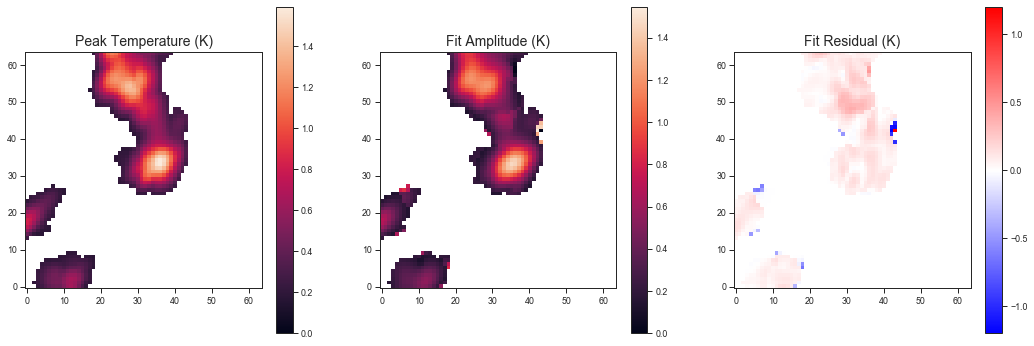

In [22]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.title('Peak Temperature (K)', fontsize=14)
plt.imshow(masked_peaktemp.value, vmin=0, origin='lower')
plt.colorbar()

plt.subplot(132)
plt.title('Fit Amplitude (K)', fontsize=14)
plt.imshow(out_test[0], vmin=0, origin='lower')
plt.colorbar()

plt.subplot(133)
plt.title('Fit Residual (K)', fontsize=14)
plt.imshow(masked_peaktemp.value - out_test[0], cmap='bwr', vmax=1.2, vmin=-1.2, origin='lower')
plt.colorbar()

print(f"Max residual: {np.nanmax(masked_moment0.value - out_test[0])}")
print(f"Min residual: {np.nanmin(masked_moment0.value - out_test[0])}")

The fit amplitudes closely match the initial guesses, though a few outliers in the fits warrant reviewing.

Next, the centroid velocity:

Max residual: 2.620709728272601
Min residual: -2.819628567830705


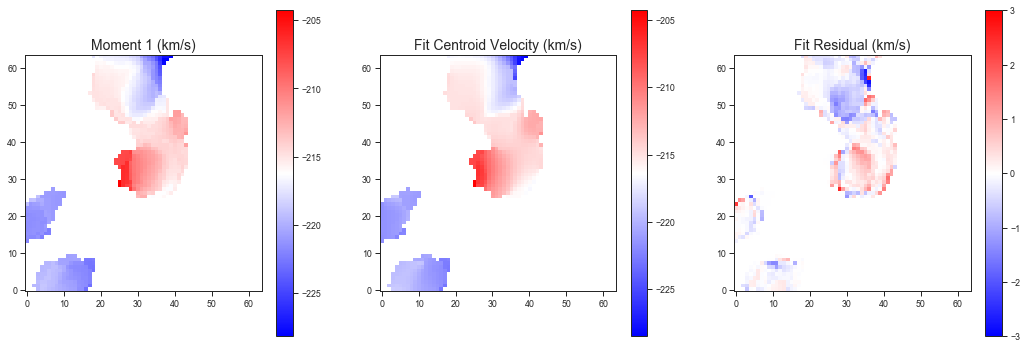

In [23]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.title('Moment 1 (km/s)', fontsize=14)
plt.imshow(masked_moment1.value, cmap='bwr', origin='lower')
plt.colorbar()

plt.subplot(132)
plt.title('Fit Centroid Velocity (km/s)', fontsize=14)
plt.imshow(out_test[1], cmap='bwr', origin='lower')
plt.colorbar()

plt.subplot(133)
plt.title('Fit Residual (km/s)', fontsize=14)
plt.imshow(masked_moment1.value - out_test[1], cmap='bwr', vmax=3, vmin=-3, origin='lower')
plt.colorbar()

print(f"Max residual: {np.nanmax(masked_moment1.value - out_test[1])}")
print(f"Min residual: {np.nanmin(masked_moment1.value - out_test[1])}")

These again are quite similar. The fitted centroid velocity looks smoother. For reference, the channel width is 0.7 km/s.

Lastly, the line widths:

Max residual: 1.1474030039027872
Min residual: -5.1946133796482785


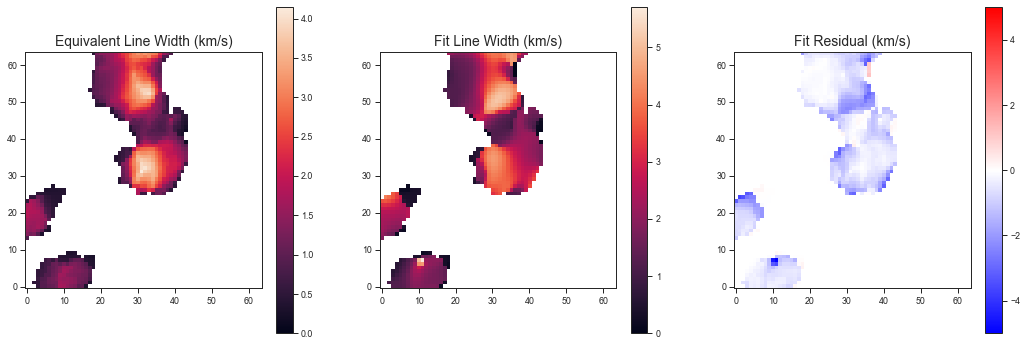

In [24]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.title('Equivalent Line Width (km/s)', fontsize=14)
plt.imshow(masked_equivwidth.value, vmin=0, origin='lower')
plt.colorbar()

plt.subplot(132)
plt.title('Fit Line Width (km/s)', fontsize=14)
plt.imshow(out_test[2], vmin=0, origin='lower')
plt.colorbar()

plt.subplot(133)
plt.title('Fit Residual (km/s)', fontsize=14)
plt.imshow(masked_equivwidth.value - out_test[2], cmap='bwr', vmax=5, vmin=-5, origin='lower')
plt.colorbar()

print(f"Max residual: {np.nanmax(masked_equivwidth.value - out_test[2])}")
print(f"Min residual: {np.nanmin(masked_equivwidth.value - out_test[2])}")

The structure in the maps has changed somewhat between the equivalent line width and fitted line width, and the fitted line width tends to be larger. This suggests (1) the equivalent line width tends to underestimate the line width, and (2) there is additional line structure that is not fully captured by a single Gaussian.

We can make one final comparison by computing the integrated intensity for the model and comparing it to the data itself:

&lt;matplotlib.colorbar.Colorbar at 0x7f0c2c238278&gt;

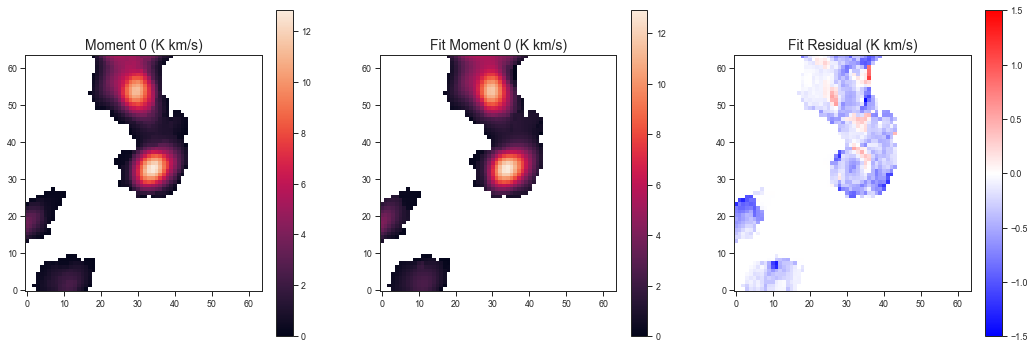

In [25]:
plt.figure(figsize=(18, 6))

integrated_intensity = np.sqrt(2 * np.pi) * out_test[0] * u.K * out_test[2] * u.km / u.s

plt.subplot(131)
plt.title('Moment 0 (K km/s)', fontsize=14)
plt.imshow(masked_moment0.value, vmin=0, origin='lower')
plt.colorbar()

plt.subplot(132)
plt.title('Fit Moment 0 (K km/s)', fontsize=14)
plt.imshow(integrated_intensity.value, vmin=0, origin='lower')
plt.colorbar()

plt.subplot(133)
plt.title('Fit Residual (K km/s)', fontsize=14)
plt.imshow(masked_moment0.value - integrated_intensity.value, cmap='bwr', vmax=1.5, vmin=-1.5, origin='lower')
plt.colorbar()


The moment 0 integrated intensity maps are similar, though the fit map tends to be larger. This is expected because of how the signal mask is created, with the $3\sigma$ signal-to-noise cut-off. Because the fit is continuous, the fitted integrated intensity may better capture the faint emission down to the noise level.

Altogether, the fitting has generally been successful for this proof-of-concept cube fitting use `dask` with `astropy.modeling`.

*Note that we have not included goodness-of-fit statistics for this example. These are, of course, crucial when using the fitting for scientific results. However, this example is primarily as a proof-of-concept and will need to be expanded and generalized for full usage.*

To evaluate the whole model cube, the 2D parameter arrays can be passed to the 1D Gaussian model:

In [26]:
full_model = models.Gaussian1D(amplitude=out_test[0], mean=out_test[1], stddev=out_test[2])

The model cube can be evaluated by passing the cube's spectral axis, though expanded to 3D:

** Be careful running the following with large cubes! This will produce an array with the same dimensions as the whole cube.**

In [27]:
model_cube = full_model(cube.spectral_axis[:, None, None].value)

And to compare, we can make an equivalent peak intensity map using the max along the spectral dimension:

&lt;matplotlib.image.AxesImage at 0x7f0c2c32ccc0&gt;

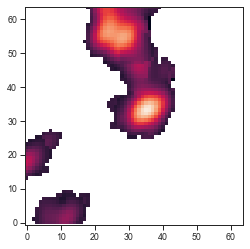

In [28]:
plt.imshow(model_cube.max(0), origin='lower')

This appears as expected. `model_cube` can be used to inspect the fits and compare to the data.

## Performance ##

For large cubes, the parallelization may become input/output (I/O) limited when dask reads in chunks of the cube. Because we require the full spectral dimension to be returned, we already may need the `DaskSpectralCube.rechunk` function. Above we use this simply to force using 16 chunks for this tutorial. However, when `zarr` and `fsspec` are installed, the rechunked cube can be temporarily saved as a zarr file by setting `save_to_tmp_dir=True`. This may improve the fitting performance at the expense of the time to write out the temporary file and the need for $\sim2\times$ the storage space.